In [1]:
# Library imports.
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from pathlib import Path
import scipy
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Urbansurge imports.
from urbansurge import swmm_model, analysis_tools, file_utils
from urbansurge.fault_diagnosis import ann_classifier, ann_regressor, dtw_knn_classifier, quant, cnn_classifier, data_utils
from urbansurge.fault_diagnosis.accuracy_metrics import true_positive_rate

# Autoreload.
%load_ext autoreload
%autoreload 2

In [2]:
# SWMM model configuration file path.
config_path = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\lab_system_config.yml"

# Node where impulse is added.
input_node = 18

# Physical model fault database path.
phy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_impulse_fault_database.csv"

# Simulation model fault database path.
sim_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_impulse_fault_database.csv"

# Physical model with no faults (i.e., "healthy" case)
phy_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\phy_healthy_impulse_database.csv"

# Simulation model with no faults (i.e., "healthy" case)
sim_healthy_save_fp = r"C:\Users\ay434\Documents\urbansurge\analysis\lab_system\diagnosis_pipeline\sim_healthy_impulse_database.csv"

# Figure save path.
fig_savefp = Path(r'C:\Users\ay434\Box\Research\Smart_Stormwater\Fault_Diagnosis_Paper\Manuscript\manuscript-v1\Figures')

In [3]:
# Create instance of SWMM model.
swmm = swmm_model.SWMM(config_path)

# Configure model.
swmm.configure_model()

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2020-01-01 00:00:00
Start Time: 2020-01-01 06:00:00


In [4]:
# Physical system fault database.
phy_db = pd.read_csv(phy_save_fp)

# Simulation system fault database.
sim_db = pd.read_csv(sim_save_fp)

# Physical healthy system run.
phy_healthy_db = pd.read_csv(phy_healthy_save_fp)

# Simulated healthy system run.
sim_healthy_db = pd.read_csv(sim_healthy_save_fp)

In [5]:
# Depth and velocity columns.
dep_vel_cols = [s for s in sim_healthy_db if any(sub in s for sub in ['Depth_link', 'Velocity'])]

# Select sensors.
links = [20, 21, 23, 45, 44, 43, 42, 41, 40, 39]
skips = [1, 2, 3, 4, 5, 10]

In [8]:
# Fault types.
fault_types = np.unique(sim_db.fault_type)

# Fault component types.
fault_type_component = {'diameter': 'Link', 'roughness': 'Link', 'silting': 'Junction'}

# Severity density arrays for storing diagnosis accuracy metrics.
severity_density_arrays = {}
severity_dict = {}
for fault_type in fault_types:
    # Severity levels.
    severity_levels = np.unique(sim_db.loc[sim_db.fault_type==fault_type, 'fault_value'])
    severity_dict[fault_type] = severity_levels

    severity_density_ar = np.zeros((len(severity_levels), len(skips)))
    severity_density_arrays[fault_type] = severity_density_ar
    print(severity_density_ar.shape)
    
# Scenarios.
scenarios = np.unique(sim_db.scenario)
scenario_fault_types = [sim_db.loc[sim_db.scenario==scenario, 'fault_type'].iloc[0] for scenario in scenarios]
scenario_fault_types = np.array(scenario_fault_types)
scenario_severities = [sim_db.loc[sim_db.scenario==scenario, 'fault_value'].iloc[0] for scenario in scenarios]
scenario_severities = np.array(scenario_severities)

(15, 6)
(15, 6)
(21, 6)


In [7]:
# Number of hours to retain.
clip_hours = 2

# Noise standard deviation.
noise_std = 0.08

In [44]:
severity_density_ar = np.zeros(())
for skip_idx, skip in enumerate(skips):
    print(skip_idx)
    # Sensor columns.
    sensor_links = links[::skip]
    print(sensor_links)
    dep_cols = [f'Depth_link_{s}' for s in sensor_links]
    vel_cols = [f'Velocity_link_{s}' for s in sensor_links]
    vel_cols = []
    dep_vel_cols = dep_cols + vel_cols

    # Clipped data frames.
    phy_db_clip = data_utils.clip_timeseries(phy_db, clip_hours)
    sim_db_clip = data_utils.clip_timeseries(sim_db, clip_hours)
    phy_healthy_db_clip = data_utils.clip_timeseries(phy_healthy_db, clip_hours, by_scenario=False) 
    sim_healthy_db_clip = data_utils.clip_timeseries(sim_healthy_db, clip_hours, by_scenario=False) 
    
    # Add noise to physical data.
    phy_db_clip[dep_vel_cols] += np.random.normal(0, noise_std, size=phy_db_clip[dep_vel_cols].shape)
    
    # Baseline observations and ensemble from multiple samples.
    n_samples = 5 # Number of times the baseline system is sampled.
    d_obs_baseline, baseline_ens_df = data_utils.generate_baseline_observations(phy_healthy_db_clip, dep_vel_cols, 
                                                                                n_samples, noise_std)
    
    # Residual data frames.
    phy_residual_df = data_utils.compute_residuals(phy_db_clip, baseline_ens_df, dep_vel_cols)
    sim_residual_df = data_utils.compute_residuals(sim_db_clip, sim_healthy_db_clip, dep_vel_cols)
    
    # Normalize residuals.
    phy_residual_norm_df = data_utils.normalize_states(swmm, phy_residual_df, sensor_links, norm_type=None)
    sim_residual_norm_df = data_utils.normalize_states(swmm, sim_residual_df, sensor_links, norm_type=None)
    phy_norm_df = data_utils.normalize_states(swmm, phy_db_clip, sensor_links, norm_type=None)
    sim_norm_df = data_utils.normalize_states(swmm, sim_db_clip, sensor_links, norm_type=None)
    
    # Reshape state variable arrays into 3D arrays where each slice is a separate scenario.
    Xphy_res, yphy_res = data_utils.prepare_states(phy_residual_norm_df, dep_vel_cols)
    Xsim_res, ysim_res = data_utils.prepare_states(sim_residual_norm_df, dep_vel_cols)
    Xphy, yphy = data_utils.prepare_states(phy_norm_df, dep_vel_cols)
    Xsim, ysim = data_utils.prepare_states(sim_norm_df, dep_vel_cols)
    
    # Create tensors to pass into ANN. 
    # 3D array where rows are time steps, columns are depth/velocity sensors, and slices are fault scenarios.
    Xsim_g = Xsim_res.transpose(1, 0, 2).reshape(-1, Xsim.shape[2]).T
    print('N features:', Xsim_g.shape)

    # Labels from simulation model for training.
    # Convert fault class column to categorical values.
    _, ysim_L = np.unique(ysim_res['fault_component'], return_inverse=True)
    
    # Create tensors to pass into ANN.
    Xphy_g = Xphy_res.transpose(1, 0, 2).reshape(-1, Xphy.shape[2]).T
    print('N features:', Xphy_g.shape)

    # Labels from simulation model for training.
    # Convert fault class column to categorical values.
    _, yphy_L = np.unique(yphy_res['fault_component'], return_inverse=True)
    
    # Compute distance between components and the outfall.
    ysim_dist = np.zeros((ysim_res.shape[0], 1))
    for i, component in enumerate(ysim_res['fault_component']):
        component_class = ysim_res.loc[i, 'fault_type']
        ysim_dist[i, 0] = swmm.upstream_distance(20, 'Link', component, fault_type_component[component_class])
        
    yphy_dist = np.zeros((yphy_res.shape[0], 1))
    for i, component in enumerate(yphy_res['fault_component']):
        component_class = yphy_res.loc[i, 'fault_type']
        yphy_dist[i, 0] = swmm.upstream_distance(20, 'Link', component, fault_type_component[component_class])
    
    #### Fault Classification ####
    # ============================================================================================
    # Train ANN Classifier
    # --------------------------------------------------------
    # Model, loss function, optimizer, and number of epochs.
    input_features = Xsim_g.shape[1]
    output_features = 1
    lr = 0.001
    criterion = nn.MSELoss()  # Use CrossEntropyLoss for classification
    num_epochs = 1000  # Set the number of epochs

    # Instantiate model.
    model_L = ann_regressor.ANNRegressor(input_features, output_features, lr, num_epochs, criterion,
                     shuffle_train=True, shuffle_test=False)
    
    # Train model.
    model_L.fit_model(Xsim_g, ysim_dist)
    
    # Test ANN Classifier
    # --------------------------------------------------------
    # Predictions and labels.
    pred_L, label_L = model_L.test_model(Xphy_g, yphy_dist)
    
    for fault_type in fault_types:
        # Severity levels.
        severity_levels = severity_dict[fault_type]
        
        for j, severity_level in enumerate(severity_levels):
            pred_L_sf = pred_L[(scenario_fault_types==fault_type) & (scenario_severities==severity_level)]
            label_L_sf = label_L[(scenario_fault_types==fault_type) & (scenario_severities==severity_level)]
            mean_distance = np.mean(np.abs(pred_L_sf - label_L_sf))
            if mean_distance > 2276:
                raise ValueError('Mean Distance cannot be greater than total length')
            severity_density_arrays[fault_type][j, skip_idx] = np.mean(np.abs(pred_L_sf - label_L_sf))
    # ============================================================================================

0
[20, 21, 23, 45, 44, 43, 42, 41, 40, 39]
N features: (246, 1210)
N features: (246, 1210)
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91

Epoch: 749
Epoch: 750
Epoch: 751
Epoch: 752
Epoch: 753
Epoch: 754
Epoch: 755
Epoch: 756
Epoch: 757
Epoch: 758
Epoch: 759
Epoch: 760
Epoch: 761
Epoch: 762
Epoch: 763
Epoch: 764
Epoch: 765
Epoch: 766
Epoch: 767
Epoch: 768
Epoch: 769
Epoch: 770
Epoch: 771
Epoch: 772
Epoch: 773
Epoch: 774
Epoch: 775
Epoch: 776
Epoch: 777
Epoch: 778
Epoch: 779
Epoch: 780
Epoch: 781
Epoch: 782
Epoch: 783
Epoch: 784
Epoch: 785
Epoch: 786
Epoch: 787
Epoch: 788
Epoch: 789
Epoch: 790
Epoch: 791
Epoch: 792
Epoch: 793
Epoch: 794
Epoch: 795
Epoch: 796
Epoch: 797
Epoch: 798
Epoch: 799
Epoch: 800
Epoch: 801
Epoch: 802
Epoch: 803
Epoch: 804
Epoch: 805
Epoch: 806
Epoch: 807
Epoch: 808
Epoch: 809
Epoch: 810
Epoch: 811
Epoch: 812
Epoch: 813
Epoch: 814
Epoch: 815
Epoch: 816
Epoch: 817
Epoch: 818
Epoch: 819
Epoch: 820
Epoch: 821
Epoch: 822
Epoch: 823
Epoch: 824
Epoch: 825
Epoch: 826
Epoch: 827
Epoch: 828
Epoch: 829
Epoch: 830
Epoch: 831
Epoch: 832
Epoch: 833
Epoch: 834
Epoch: 835
Epoch: 836
Epoch: 837
Epoch: 838
Epoch: 839

ValueError: Mean Distance cannot be greater than total length

[[4336.674]]
[[1265.]]


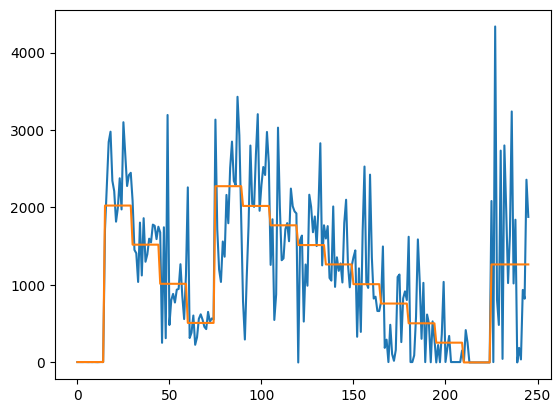

In [45]:
print(pred_L_sf)
print(label_L_sf)
np.mean(np.abs(pred_L_sf - label_L_sf))

fig, ax = plt.subplots()
ax.plot(pred_L)
ax.plot(label_L)

Total Length = 2275.0 ft
Total Length = 2275.0 ft
Total Length = 2275.0 ft


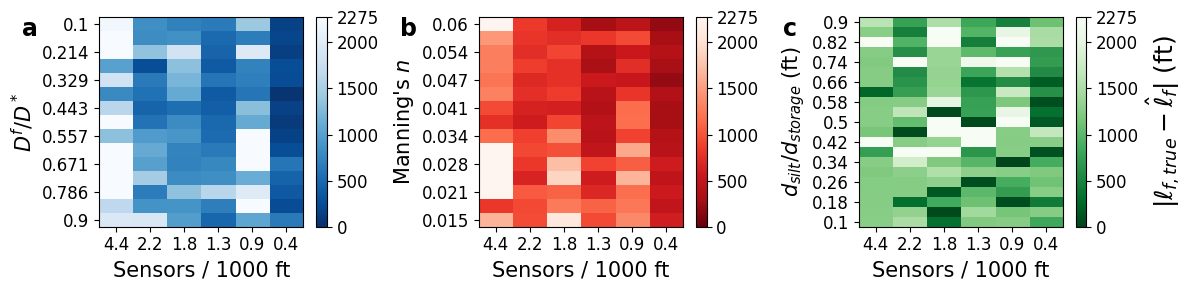

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
for i, fault_type in enumerate(fault_types):
    # Fault type to plot.
#     fault_type = 'roughness'

    # Colormap names.
    if fault_type == 'diameter':
        cmap_name = 'Blues_r'
        ylabel = '$D^f / D^*$'
        severities = severity_dict[fault_type][::-1]
        yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
#         cbar_ticks = [0, 1000, 2000, 3000]
    elif fault_type == 'roughness':
        cmap_name = 'Reds_r'
        ylabel = "Manning's $n$"
        severities = severity_dict[fault_type] * 0.01 
        yticks = np.linspace(0.015, 0.06, 4)
#         cbar_ticks = [0, 1000, 2000, 3000]
    elif fault_type == 'silting':
        cmap_name = 'Greens_r'
        ylabel = '$d_{silt} / d_{storage}$ (ft)'
        severities = severity_dict[fault_type]
        yticks = [0.1, 0.3, 0.5, 0.7, 0.9]
#         cbar_ticks = [0, 2000, 4000, 6000, 8000]

    # Plotting array.
    plotting_ar = severity_density_arrays[fault_type]
    nrow, ncol = plotting_ar.shape

    # Total length of flow path.
    total_length = swmm.upstream_distance(20, 'Link', 18, 'Junction')
    print(f'Total Length = {total_length} ft')

    # Number of sensors at each density.
    n_sensors = [10, 5, 4, 3, 2, 1]

    # Sensors / distance.
    dist = 1000
    sensors_per_dist = n_sensors / total_length * dist

#     fig, ax = plt.subplots()
    ax = axes[i]
    vmax = np.max(plotting_ar)
    cf = ax.imshow(np.fliplr(plotting_ar), cmap=cmap_name, origin='lower', aspect='auto', vmin=0, vmax=total_length)
    cbar = fig.colorbar(cf, ax=ax)
    if i == 2:
        cbar.set_label('$|\ell_{f,true} - \\hat{\ell}_f|$ (ft)', fontsize=18)
    cbar.ax.tick_params(labelsize=12)
    cbar_ticks = cbar.get_ticks()
    cbar.set_ticks(np.append(cbar_ticks[:-1], total_length))
    ax.set_xlabel(f'Sensors / {dist} ft', fontsize=15)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.tick_params(axis='both', labelsize=12)
    # X-ticks.
    xtick_idx = np.arange(0, ncol, 1)
    ax.set_xticks(xtick_idx)
    ax.set_xticklabels(np.round(sensors_per_dist, 1))
    # Y-ticks.
    ytick_idx = np.arange(0, nrow, 2)
    ax.set_yticks(ytick_idx)
    ax.set_yticklabels(np.round(severities[ytick_idx], 3))
    
    # Add subfigure letter.
    halign=1
    subplot_labels = ['a', 'b', 'c']
    ax.text(-0.3, halign, subplot_labels[i],
        transform=ax.transAxes,  # Coordinates relative to the axis (0,0) to (1,1)
        fontsize=17,             # Font size
        verticalalignment='top', # Align text to the top
        horizontalalignment='right',  # Align text to the right
        weight='bold')
    
fig.tight_layout()
fig.savefig(fig_savefp / 'localization_accuracy.png', dpi=300)